In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [2]:
import jax.numpy as jnp
from jax import jit, vmap, grad
from jax import random

In [3]:
key = random.PRNGKey(0)
x = random.normal(key, (10,))
print(x)

[-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


In [4]:
size = 3000
x = random.normal(key, (size, size), dtype=jnp.float32)
%timeit jnp.dot(x, x.T).block_until_ready()

13.3 ms ± 318 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
import numpy as np
x = np.random.normal(size=(size, size)).astype(np.float32)
%timeit jnp.dot(x, x.T).block_until_ready()

43.2 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
import numpy as np
x = np.random.normal(size=(size, size)).astype(np.float32)
%timeit jnp.dot(x, x.T).block_until_ready()

45.1 ms ± 1.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Using jit() to speed up functions.

In [7]:
from jax._src.api import block_until_ready
def selu(x, alpha=1.67, lmbda=1.05):
  return lmbda * jnp.where(x>0, x, alpha * jnp.exp(x) - alpha)
x = random.normal(key, shape=(100000, ))
%timeit selu(x).block_until_ready()


1.06 ms ± 97.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
selu_jit = jit(selu)
%timeit selu_jit(x).block_until_ready()

55.3 µs ± 821 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Taking derivatives with grad()

In [9]:
def sum_logistic(x):
  return jnp.sum(1. / (1. + jnp.exp(-x)))
x_small = jnp.arange(3.)
derivative_fn = grad(sum_logistic)
print(derivative_fn(x_small)) 

[0.25       0.19661194 0.10499357]


let's verify with finite differences that our result is correct

In [10]:
def first_finite_difference(f, x):
  eps = 1e-3
  return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2*eps) for v in jnp.eye(len(x))])
print(first_finite_difference(sum_logistic, x_small))

[0.24998187 0.1965761  0.10502338]


In [11]:
print(grad(jit(grad(jit(grad(sum_logistic)))))(1.0))

-0.0353256


Auto-vectorization with vmap()

In [12]:
mat = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))
def apply_matrix(v):
  return jnp.dot(mat, v)
def naively_batched_apply_matrix(v_batched):
  return jnp.stack([apply_matrix(v) for v in v_batched])
print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
3.02 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
@jit
def batched_apply_matrix(v_batched):
  return jnp.dot(v_batched, mat.T)
print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
98.8 µs ± 900 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
@jit
def vmap_batched_apply_matrix(v_batched):
  return vmap(apply_matrix)(v_batched)
print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
51.7 µs ± 3.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Jax vs. Numpy

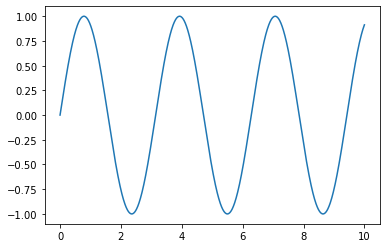

In [15]:
import matplotlib.pyplot as plt
import numpy as np

x_np = np.linspace(0, 10, 1000)
y_np = 2 * np.sin(x_np) * np.cos(x_np)
plt.plot(x_np, y_np);

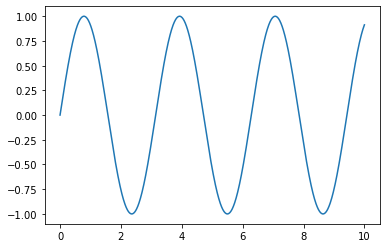

In [16]:
x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp);

In [17]:
print(type(x_np))
print(type(x_jnp))

<class 'numpy.ndarray'>
<class 'jaxlib.xla_extension.DeviceArray'>


There is one important difference between JAX and NumPy.arrays: JAX arrays are immutable, meaning that once created their contents cannot be changed

In [18]:
x = np.arange(10)
x[0] = 10
x

array([10,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [19]:
x = jnp.arange(10)
# x[0] = 10, Jax is immutable, using x = x.at[idx].set(value) insted.
x = x.at[0].set(10)
x

DeviceArray([10,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int32)

## NumPy, lax & XLA: JAX API layering
### **Key concepts:**
*   jax.numpy is a high level wraper that provides with a familiar interface.
*   jax.lax is a lower-level API that is stricter and often more powerful
*   All jax operations are implemented in terms of operations in XLA-the Accelerated Linear Algebra compiler.





In [20]:
jnp.add(1, 1.0)

DeviceArray(2., dtype=float32, weak_type=True)

# To JIT or not to JIT

In [21]:
import jax.numpy as jnp

def norm(X):
  X = X - X.mean(0)
  return X / X.std(0)

In [22]:
from jax import jit
norm_compiled = jit(norm)

In [23]:
np.random.seed(1701)
X = jnp.array(np.random.rand(10000, 10))
np.allclose(norm(X), norm_compiled(X), atol=1E-6)

True

In [24]:
%timeit norm(X).block_until_ready()
%timeit norm_compiled(X).block_until_ready()

350 µs ± 7.76 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
98.5 µs ± 14.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


JIT needs array be static

In [25]:
def get_negatives(x):
  return x[x < 0]

x = jnp.array(np.random.randn(10))
get_negatives(x)

DeviceArray([-0.10570311, -0.59403396, -0.8680282 , -0.23489487], dtype=float32)

In [26]:
# jit(get_negatives)(x)

In [27]:

def f(x, y):
  print("Running f():")
  print(f"  x = {x}")
  print(f"  y = {y}")
  result = jnp.dot(x + 1, y + 1)
  print(f"  result = {result}")
  return result

x = np.random.randn(3, 4)
y = np.random.randn(4)
f(x, y)
%timeit f(x, y)

Running f():
  x = [[ 0.24124517 -1.25714202 -0.48511598 -0.98639282]
 [ 1.39783022  0.48784978  1.90996403 -0.26037156]
 [-0.49505737  1.34450656  0.59428027  0.61083763]]
  y = [-0.57855466  1.05148987 -0.48361592 -1.27473592]
  result = [0.2577323 5.3623195 5.403243 ]
Running f():
  x = [[ 0.24124517 -1.25714202 -0.48511598 -0.98639282]
 [ 1.39783022  0.48784978  1.90996403 -0.26037156]
 [-0.49505737  1.34450656  0.59428027  0.61083763]]
  y = [-0.57855466  1.05148987 -0.48361592 -1.27473592]
  result = [0.2577323 5.3623195 5.403243 ]
Running f():
  x = [[ 0.24124517 -1.25714202 -0.48511598 -0.98639282]
 [ 1.39783022  0.48784978  1.90996403 -0.26037156]
 [-0.49505737  1.34450656  0.59428027  0.61083763]]
  y = [-0.57855466  1.05148987 -0.48361592 -1.27473592]
  result = [0.2577323 5.3623195 5.403243 ]
Running f():
  x = [[ 0.24124517 -1.25714202 -0.48511598 -0.98639282]
 [ 1.39783022  0.48784978  1.90996403 -0.26037156]
 [-0.49505737  1.34450656  0.59428027  0.61083763]]
  y = [-0.5

In [28]:
x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
%timeit f(x2, y2)

Running f():
  x = [[-0.82886446 -0.96895962  0.31626638 -1.30240421]
 [ 1.42542593 -0.01968225 -1.03792854 -1.98280329]
 [ 0.29157075 -0.1554043   0.87975108 -0.14639181]]
  y = [0.88247808 0.76965426 0.25971301 0.98657674]
  result = [1.4344586 4.3004417 7.9897017]
Running f():
  x = [[-0.82886446 -0.96895962  0.31626638 -1.30240421]
 [ 1.42542593 -0.01968225 -1.03792854 -1.98280329]
 [ 0.29157075 -0.1554043   0.87975108 -0.14639181]]
  y = [0.88247808 0.76965426 0.25971301 0.98657674]
  result = [1.4344586 4.3004417 7.9897017]
Running f():
  x = [[-0.82886446 -0.96895962  0.31626638 -1.30240421]
 [ 1.42542593 -0.01968225 -1.03792854 -1.98280329]
 [ 0.29157075 -0.1554043   0.87975108 -0.14639181]]
  y = [0.88247808 0.76965426 0.25971301 0.98657674]
  result = [1.4344586 4.3004417 7.9897017]
Running f():
  x = [[-0.82886446 -0.96895962  0.31626638 -1.30240421]
 [ 1.42542593 -0.01968225 -1.03792854 -1.98280329]
 [ 0.29157075 -0.1554043   0.87975108 -0.14639181]]
  y = [0.88247808 0.769

# In-Place Updates

In [29]:
jax_array = jnp.zeros((3,3), dtype=jnp.float32)
try:
  jax_array[1, :] = 1.0
except Exception as e:
  print('Exception{}'.format(e))


Exception'<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html


# Control Flow
## ✈ python control-flow + autodiff ✈

In [30]:
def f(x):
  if x > 3:
    return 3 * x ** 2
  else:
    return -4 * x
print(grad(f)(2.0))
print(grad(f)(4.0))
print(grad(grad(f))(4.0))

-4.0
24.0
6.0


## python control-flow + JIT

In [31]:
@jit
def f(x):
  for i in range(3):
    x = 2 * x
  return x
print(f(3))

24


In [32]:

@jit
def g(x):
  y = 0.
  for i in range(x.shape[0]):
    y = y + x[i]
  return y
print(g(jnp.array([1., 2., 3.])))


6.0


In [33]:
@jit
def f(x):
  if x > 3:
    return 3 * x ** 2
  else:
    return -4 * x
try:
  f(2)
except Exception as e:
  print("Exception:{}".format(e))

Exception:Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
The problem arose with the `bool` function. 
The error occurred while tracing the function f at <ipython-input-33-047313512968>:1 for jit. This concrete value was not available in Python because it depends on the value of the argument 'x'.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError


In [34]:
def f(x):
  if x < 3:
    return 3. * x ** 2
  else:
    return -4 * x

f = jit(f, static_argnums=(0,))

print(f(2.))



12.0


# Tutorial of JAX

The code below shows how to import JAX and creat a vector

In [35]:
import jax
import jax.numpy as jnp
x = jnp.arange(10)
print(x)
x

[0 1 2 3 4 5 6 7 8 9]


DeviceArray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

One useful feature of jax is that the same code can be run on different backends-CPU, GPU or TPU. We will now perform a dot product to demonstrate that it can be done in differnet device without changing the code. We use %timeit to check the performance.

In [36]:
long_vector = jnp.arange(int(1e7))
%timeit jnp.dot(long_vector, long_vector).block_until_ready()

346 µs ± 25.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
def sum_of_squares(x):
  return jnp.sum(x**2)
sum_of_square_dx = jax.grad(sum_of_squares)
x = jnp.asarray([1., 2., 3., 4.])
print(sum_of_squares(x))
print(sum_of_square_dx(x))

30.0
[2. 4. 6. 8.]


In [38]:
def sum_squared_error(x, y):
  return jnp.sum((x - y) ** 2)
sum_squared_error_dx = jax.grad(sum_squared_error)
y = jnp.asarray([1.1, 2.1, 3.1, 4.1])
print(sum_squared_error_dx(x, y)) # grad默认对第一个参数求导
print(jax.grad(sum_squared_error, argnums=(0, 1))(x, y)) # 使用argnums可以指定对哪些参量求导

[-0.20000005 -0.19999981 -0.19999981 -0.19999981]
(DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32), DeviceArray([0.20000005, 0.19999981, 0.19999981, 0.19999981], dtype=float32))


with value and grad calculated togother using fun: value_and_grad

In [39]:
jax.value_and_grad(sum_squared_error, argnums=(0, 1))(x, y)

(DeviceArray(0.03999995, dtype=float32),
 (DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
  DeviceArray([0.20000005, 0.19999981, 0.19999981, 0.19999981], dtype=float32)))

In [41]:
# def squared_error_with_aux(x, y):
#   return sum_squared_error(x, y), x-y

# jax.grad(squared_error_with_aux)(x, y)

In [42]:
def squared_error_with_aux(x, y):
  return sum_squared_error(x, y), x-y

jax.grad(squared_error_with_aux, has_aux=True)(x, y) 
# if returned value is a tuble, we can use has_aux to handle the error.

(DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 DeviceArray([-0.10000002, -0.0999999 , -0.0999999 , -0.0999999 ], dtype=float32))

10.677573680877686
w: 3.00, b: -0.99


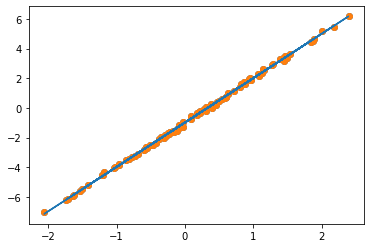

In [43]:
import numpy as np
import jax.numpy as jnp
import jax
import time
import matplotlib.pyplot as plt

xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys);
def model(theta, x):
  """Computes wx + b on a batch of input x."""
  w, b = theta
  return w * x + b
def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

def update(theta, x, y, lr=0.1):
  return theta - lr * jax.grad(loss_fn)(theta, x, y)
theta = jnp.array([1., 1.])

start = time.time()
for _ in range(1000):
  theta = update(theta, xs, ys)
end = time.time()
tot_time = end - start
print(tot_time)
plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")

# Working with Pytree

In [45]:
import jax
import jax.numpy as jnp
example_trees = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),]
for pytree in example_trees:
  leaves = jax.tree_leaves(pytree)
  print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")


[1, 'a', <object object at 0x7f4fe53b1850>]   has 3 leaves: [1, 'a', <object object at 0x7f4fe53b1850>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
DeviceArray([1, 2, 3], dtype=int32)           has 1 leaves: [DeviceArray([1, 2, 3], dtype=int32)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  # Remove the CWD from sys.path while we load stuff.


[1, 'a', <object object at 0x7f4fe53b1920>]   has 3 leaves: [1, 'a', <object object at 0x7f4fe53b1920>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
DeviceArray([1, 2, 3], dtype=int32)           has 1 leaves: [DeviceArray([1, 2, 3], dtype=int32)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  # Remove the CWD from sys.path while we load stuff.


Example: ML model parameters

In [54]:
import numpy as np
def init_mlp_params(layer_widths):
  params = []
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2 / n_in), biases=np.ones(shape=(n_out, ))))
  return params
params = init_mlp_params([1, 128, 128, 1])
jax.tree_map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [60]:

def forward(params, x):
  *hidden, last = params
  for layer in hidden:
    x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
  return x @ last['weights'] + last['biases']

def loss_fn(params, x, y):
  return jnp.mean((forward(params, x) - y) ** 2)
LEARNING_RATE = 0.0001
@jax.jit
def update(params, x, y):
  grads = jax.grad(loss_fn)(params, x, y)
  # Note that `grads` is a pytree with the same structure as `params`.
  # `jax.grad` is one of the many JAX functions that has
  # built-in support for pytrees.

  # This is handy, because we can apply the SGD update using tree utils:
  return jax.tree_map(lambda p, g: p - LEARNING_RATE * g, params, grads)

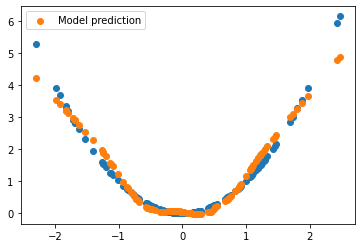

In [61]:
import matplotlib.pyplot as plt
xs = np.random.normal(size=(128, 1))
ys = xs ** 2
for _ in range(1000):
  params = update(params, xs, ys)
plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend();


In [1]:
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

# The Autodiff Cookbook

## Computing gradients with grad in a linear logistic regression model

In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

key = random.PRNGKey(0)


In [2]:
def sigmoid(x):
    return 0.5 * (jnp.tanh(x / 2) + 1)

# Outputs probability of a label being true.
def predict(W, b, inputs):
    return sigmoid(jnp.dot(inputs, W) + b)

# Build a toy dataset.
inputs = jnp.array([[0.52, 1.12,  0.77],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39]])
targets = jnp.array([True, True, False, True])

# Training loss is the negative log-likelihood of the training examples.
def loss(W, b):
    preds = predict(W, b, inputs)
    label_probs = preds * targets + (1 - preds) * (1 - targets)
    return -jnp.sum(jnp.log(label_probs))

# Initialize random model coefficients
key, W_key, b_key = random.split(key, 3)
W = random.normal(W_key, (3,))
b = random.normal(b_key, ())
# Differentiate `loss` with respect to the first positional argument:
W_grad = grad(loss, argnums=0)(W, b)
print('W_grad', W_grad)

# Since argnums=0 is the default, this does the same thing:
W_grad = grad(loss)(W, b)
print('W_grad', W_grad)

# But we can choose different values too, and drop the keyword:
b_grad = grad(loss, 1)(W, b)
print('b_grad', b_grad)

# Including tuple values
W_grad, b_grad = grad(loss, (0, 1))(W, b)
print('W_grad', W_grad)
print('b_grad', b_grad)

W_grad [-0.16965583 -0.8774647  -1.4901344 ]
W_grad [-0.16965583 -0.8774647  -1.4901344 ]
b_grad -0.29227248
W_grad [-0.16965583 -0.8774647  -1.4901344 ]
b_grad -0.29227248


In [3]:
def loss2(params_dict):
  preds = predict(params_dict['W'], params_dict['b'], inputs)
  label_probs = preds * targets + (1 - preds) * (1 - targets)
  return -jnp.sum(jnp.log(label_probs))

print(grad(loss2)({'W': W, 'b': b}))


{'W': DeviceArray([-0.16965583, -0.8774647 , -1.4901344 ], dtype=float32), 'b': DeviceArray(-0.29227248, dtype=float32)}
